<a href="https://colab.research.google.com/github/Rohan5076/AIMLOPS/blob/main/M5_NB_MiniProject_1_ResumeClassification_Using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project 1: Resume Classification

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data preprocessing, EDA on the resume dataset
* fine-tune Bert model for resume classification

## Dataset Description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

##  Grading = 10 Points

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decisionmaking.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

**Problem Statement:** Fine-tune a pre-trained Bert model for resume classification.

*For fine-tuning Bert, refer to the demo session on 'HuggingFace platform' held on 17 Aug.*

### Install dependencies

After installing the below dependencies ***Restart the session/runtime***.

In [1]:
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00


### <font color="#990000">Restart Session/Runtime</font>

### Import required packages

In [1]:
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Downloading the data

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/UpdatedResumeDataSet.csv
!ls | grep '.csv'

UpdatedResumeDataSet.csv


**Exercise 1: Read the UpdatedResumeDataset.csv dataset [0.5 Mark]**

**Hint:** pd.read_csv( , encoding='utf-8')

In [3]:
# Read the dataset
df = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')

In [4]:
df.columns

Index(['Category', 'Resume'], dtype='object')

### Pre-processing and EDA

**Exercise 2: Display  all the categories of resumes and their counts in the dataset [0.5 Mark]**



In [82]:
# Display the distinct categories of resume
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [83]:
# Displaying the number of distinct categories of resume
df['Category'].nunique()

25

In [84]:
# Display the distinct categories of resume and the number of records belonging to each category
df['Category'].value_counts()

,count
Category,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Blockchain,40
ETL Developer,40


**Exercise 3: Create the count plot of different categories [0.5 Mark]**

**Hint:** Use `sns.countplot()`

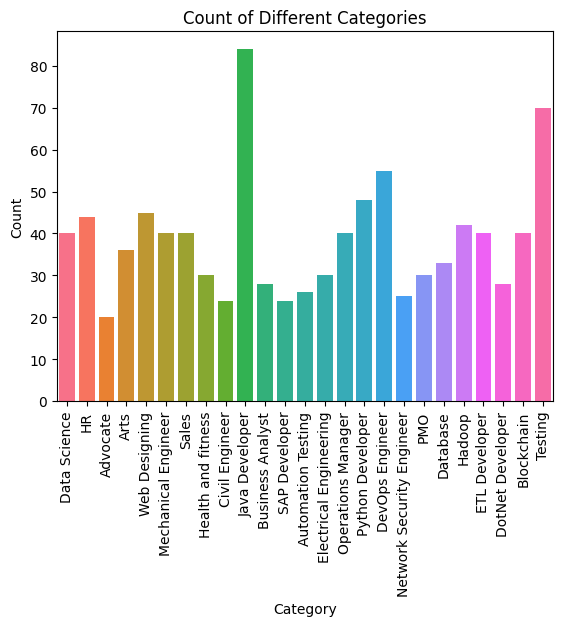

In [85]:
ax = sns.countplot(x='Category', data=df)
plt.title('Count of Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
categories = df['Category'].value_counts().index
palette = sns.color_palette("husl", len(categories))
for i, category in enumerate(categories):
    ax.patches[i].set_facecolor(palette[i])
plt.show()

**Exercise 4: Create a pie plot depicting the percentage of resume distributions category-wise. [0.5 mark]**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

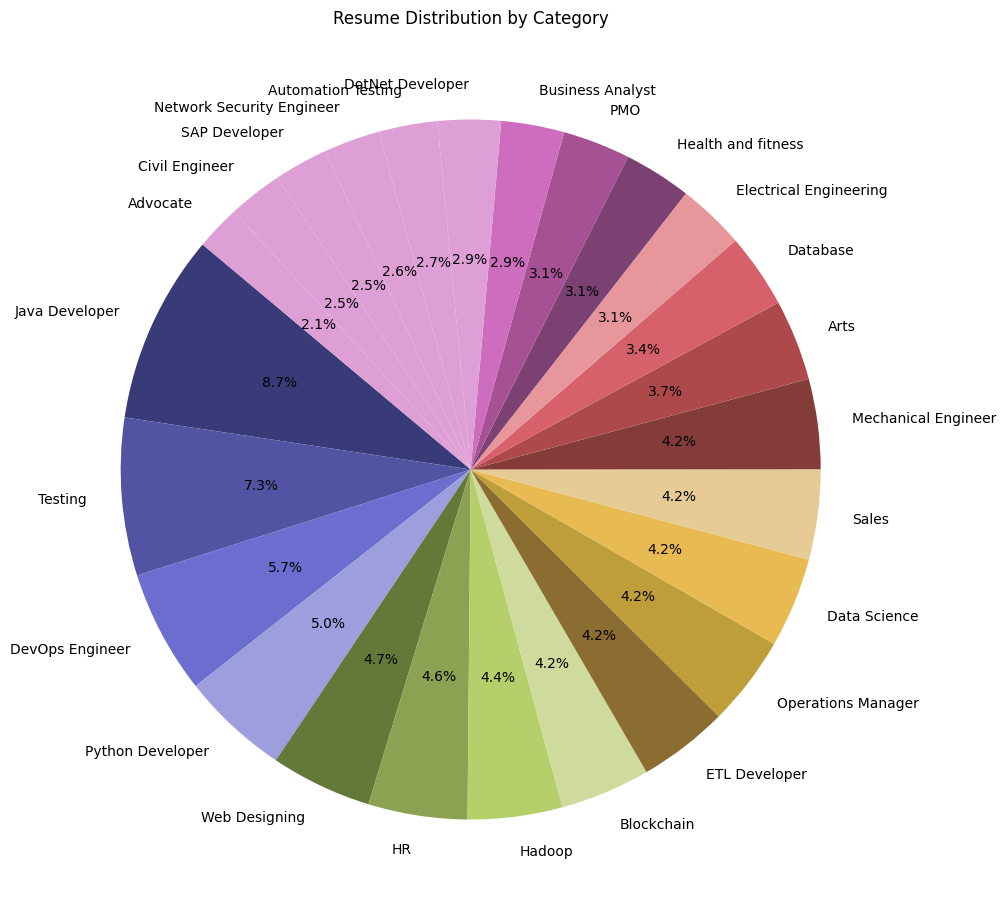

In [86]:
targetCounts = df['Category'].value_counts()
targetLabels  = targetCounts.index
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

#colors = plt.get_cmap('coolwarm')(range(len(targetCounts)))

colors = plt.get_cmap('tab20')(range(len(targetCounts)))  # 'tab20' colormap can handle up to 20 distinct colors

# If there are more than 20 categories, you might want to use a larger colormap or create your own list
if len(targetCounts) > 20:
    colors = plt.get_cmap('tab20b')(range(len(targetCounts)))  # 'tab20b' provides more colors

# Create a pie chart with different colors
plt.subplot(the_grid[0, 0])  # Create a subplot for the pie chart
plt.pie(targetCounts, labels=targetLabels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Resume Distribution by Category')

# Display the plot
plt.show()

**Exercise 5: Convert all the `Resume` text to lower case and remove trailing spaces [0.5 Mark]**




In [5]:
# Convert all characters to lowercase and remove trailing spaces
#df['Category'] = df['Category'].str.lower().str.strip()
df['Resume'] = df['Resume'].str.lower().str.strip()

### Cleaning Resume

**Exercise 6: Define a function to clean the resume text [2 Mark]**

In the text there are special characters, urls, hashtags, mentions, etc. You need to remove for the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature say `Cleaned_Resume`).


In [6]:
import re
import string
def cleanResume(resumeText):
    text = re.sub(r'http\S+', '', resumeText) # Remove URLs
    text = re.sub(r'\bRT\b|\bcc\b', '', resumeText) # Remove RT | cc
    text = re.sub(r'#\S+|@\S+', '', resumeText) # Remove hashtags (#) and mentions (@)
    text = resumeText.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = ' '.join(resumeText.split())     # Remove extra whitespace
    return resumeText



In [7]:
# Apply the function defined above and save the
df['Cleaned_Resume'] =  df['Resume'].apply(cleanResume)

**Exercise 7: Convert the categorical variable `Category` to a numerical feature and make a different column <font color="#990000">`label`</font>, which can be treated as the target variable [0.5 Mark]**

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df['Category'])

**Exercise 8: Plot the histogram of words count of `Cleaned_Resume` text [0.5 Mark]**

**Hint:** Use sns.distplot()

In [9]:
df['Count'] = df['Cleaned_Resume'].apply(lambda x: len(x.split()))

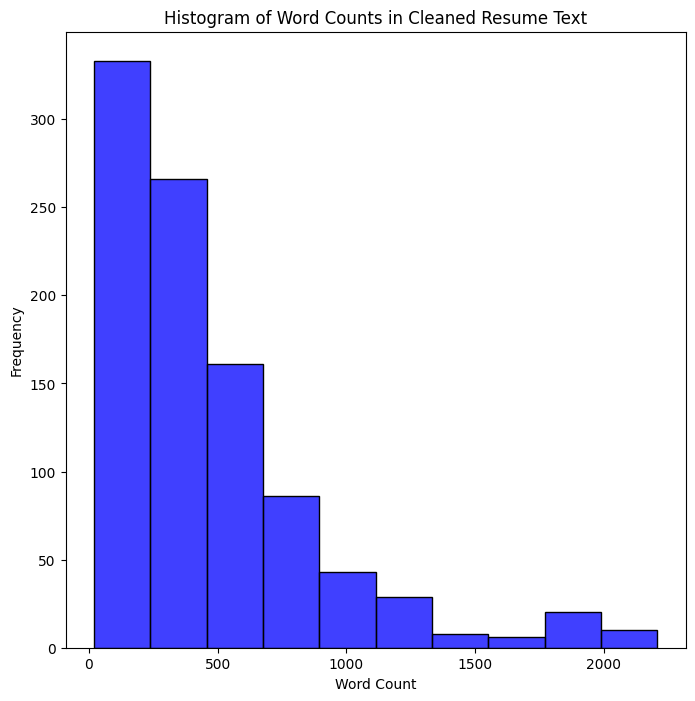

In [10]:
plt.figure(figsize= (8, 8))
sns.histplot(df['Count'], kde=False, bins=10, color='blue')
plt.title('Histogram of Word Counts in Cleaned Resume Text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Train Test Split

**Exercise 9: Split the dataset into training, validation, and testing set [0.5 Mark]**

* Do stratified splitting using `label` column

In [11]:
train_test_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, test_df = train_test_split(train_test_df, test_size=0.25, stratify=train_test_df['label'], random_state=42)

len(train_df), len(val_df), len(test_df)

(576, 193, 193)

In [12]:
train_df.head(2)

,Category,Resume,Cleaned_Resume,label,Count
821,ETL Developer,education details \r\njanuary 2015 bachelor of...,education details \r\njanuary 2015 bachelor of...,10,284
238,Sales,it skills: ms office. photoshop. sql server.ed...,it skills: ms office. photoshop. sql server.ed...,22,249


### Convert to HuggingFace Dataset

**Exercise 10: Convert Pandas dataframe to HuggingFace Dataset [1 Mark]**

**Hint:**

    import pandas as pd
    from datasets import Dataset, DatasetDict

    tdf = pd.DataFrame({"a": [1, 2, 3], "b": ['hello', 'ola', 'thammi']})
    vdf = pd.DataFrame({"a": [4, 5, 6], "b": ['four', 'five', 'six']})
    tds = Dataset.from_pandas(tdf)
    vds = Dataset.from_pandas(vdf)

    ds = DatasetDict()

    ds['train'] = tds
    ds['validation'] = vds

    print(ds)

In [13]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

ds = DatasetDict()

ds['train'] = train_ds
ds['validation'] = val_ds
ds['test'] = test_ds

### Tokenizer

**Exercise 11: Load tokenizer for checkpoint `distilbert-base-uncased` [0.5 Mark]**

**Hint:** `AutoTokenizer`

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
def tokenize_fn(batch):
     return tokenizer(batch['Cleaned_Resume'], padding='max_length', truncation=True)


In [16]:
tokenized_datasets = ds.map(tokenize_fn, batched=True)
tokenized_datasets

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Category', 'Resume', 'Cleaned_Resume', 'label', 'Count', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 576
    })
    validation: Dataset({
        features: ['Category', 'Resume', 'Cleaned_Resume', 'label', 'Count', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 193
    })
    test: Dataset({
        features: ['Category', 'Resume', 'Cleaned_Resume', 'label', 'Count', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 193
    })
})

### Load Pre-Trained Model

**Exercise 12: Load pre-trained Bert model with checkpoint `distilbert-base-uncased` and show model summary [0.5 Mark]**

**Hint:** `AutoModelForSequenceClassification`

In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=25)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Exercise 13: Freeze/Un-Freeze different layers  [0.5 Mark]**

**Hint:** Freeze layers starting with name *distilbert*


In [18]:
# Display layers name

print("Layer names:")
for name, param in model.named_parameters():
    print(name)

Layer names:
distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_nor

In [19]:
# Freezing
def freeze_layers(model):
    for name, param in model.named_parameters():
        if name.startswith('distilbert'):
            param.requires_grad = False

def unfreeze_layers(model):
    for name, param in model.named_parameters():
        if name.startswith('distilbert'):
            param.requires_grad = True

# Freeze layers starting with 'distilbert'
freeze_layers(model)

In [20]:
# Display layers gradient
print("\nLayer gradient status after freezing:")
for name, param in model.named_parameters():
    if name.startswith('distilbert'):
        print(f"{name}: requires_grad={param.requires_grad}")


# Unfreeze layers starting with 'distilbert'
unfreeze_layers(model)

# Display the gradient status of layers after unfreezing
print("\nLayer gradient status after unfreezing:")
for name, param in model.named_parameters():
    if name.startswith('distilbert'):
        print(f"{name}: requires_grad={param.requires_grad}")


Layer gradient status after freezing:
distilbert.embeddings.word_embeddings.weight: requires_grad=False
distilbert.embeddings.position_embeddings.weight: requires_grad=False
distilbert.embeddings.LayerNorm.weight: requires_grad=False
distilbert.embeddings.LayerNorm.bias: requires_grad=False
distilbert.transformer.layer.0.attention.q_lin.weight: requires_grad=False
distilbert.transformer.layer.0.attention.q_lin.bias: requires_grad=False
distilbert.transformer.layer.0.attention.k_lin.weight: requires_grad=False
distilbert.transformer.layer.0.attention.k_lin.bias: requires_grad=False
distilbert.transformer.layer.0.attention.v_lin.weight: requires_grad=False
distilbert.transformer.layer.0.attention.v_lin.bias: requires_grad=False
distilbert.transformer.layer.0.attention.out_lin.weight: requires_grad=False
distilbert.transformer.layer.0.attention.out_lin.bias: requires_grad=False
distilbert.transformer.layer.0.sa_layer_norm.weight: requires_grad=False
distilbert.transformer.layer.0.sa_laye

### Metrics

In [21]:
from datasets import load_metric
metric = load_metric("glue", "sst2")         # Type 'Y' when prompted

The repository for glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [22]:
metric.compute(predictions=[1,0,1], references=[1,0,0])

{'accuracy': 0.6666666666666666}

In [23]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits,axis=-1)
    return metric.compute(predictions=predictions,references=labels)


**Exercise 14: Fine-tune model on train dataset  [0.5 Mark]**
 * Create `TrainingArguments` class object
 * Create `Trainer` class  object
 * Train it for higher number of epochs say 40 or 50
 * Switch to GPU runtime if needed

**Hint:** Check if the training code is running without any error with CPU runtime, later switch to GPU runtime for faster training. Once trained, save the model, create its zip file, and download into your system.

In [24]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import Trainer, TrainingArguments, AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [26]:
# Set up the training arguments

model_output_path = "/content/bert_model"

training_args = TrainingArguments(
    output_dir= model_output_path,              # Directory to save the model
    evaluation_strategy="epoch",                # Evaluate every epoch
    learning_rate=2e-5,                         # Learning rate
    per_device_train_batch_size=8,              # Batch size for training
    per_device_eval_batch_size=8,               # Batch size for evaluation
    num_train_epochs=40,                        # Number of epochs
    weight_decay=0.01,                          # Weight decay
    logging_dir='/content/logs',                # Directory to save logs
    logging_steps=10,                           # Number of steps between logging
)

In [27]:
model_name = "bert-base-uncased"

In [28]:
# Load the pre-trained model configuration
config = AutoConfig.from_pretrained(model_name, num_labels=25)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
# Train the model

trainer = Trainer(
    model=model,                               # The model to train
    args=training_args,                        # Training arguments
    train_dataset=tokenized_datasets['train'], # Training dataset
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.920300,2.826889,0.347150
2,2.254800,2.090674,0.715026
3,1.535400,1.366382,0.911917
4,0.936700,0.775459,0.963731
5,0.533800,0.407525,0.968912
6,0.232200,0.198006,0.994819
7,0.130800,0.099353,0.994819
8,0.064400,0.064280,0.994819
9,0.038500,0.052051,0.994819
10,0.027800,0.045836,0.994819


KeyboardInterrupt: 

### Save Model

In [30]:
trainer.save_model(model_output_path)

In [31]:
tokenizer.save_pretrained(model_output_path)

('/content/bert_model/tokenizer_config.json',
 '/content/bert_model/special_tokens_map.json',
 '/content/bert_model/vocab.txt',
 '/content/bert_model/added_tokens.json',
 '/content/bert_model/tokenizer.json')

In [32]:
# Save the model
trainer.save_model('saved_bert_model')

In [33]:
!ls

bert_model  logs  sample_data  saved_bert_model  UpdatedResumeDataSet.csv


In [34]:
# Create a Zip file and download
!zip -r saved_bert_model.zip saved_bert_model

  adding: saved_bert_model/ (stored 0%)
  adding: saved_bert_model/config.json (deflated 64%)
  adding: saved_bert_model/training_args.bin (deflated 52%)
  adding: saved_bert_model/model.safetensors (deflated 8%)


### Load Model

**Exercise 15: Load the saved model and create a pipeline to perform text classification [1 Mark]**

 * Create the pipeline object for text classification
 * Create a `make_prediction` function to use pipeline object and output the prediction label

**Hint:** pipeline()

In [35]:
from transformers import pipeline

In [36]:
my_model = pipeline(
    'text-classification',
    model=model_output_path,
    tokenizer=model_output_path,
    device='cuda'
)

In [37]:
# Function to predict label for a resume text

def make_prediction(input_text):
    result = my_model(input_text)
    # result[0]['label']
    predicted_label = result[0]['label']
    label_index = int(predicted_label.split('_')[1])
    category = label_encoder.inverse_transform([label_index])[0]

    return category



In [38]:
# Test prediction
make_prediction('programming, web designing, coding')

'Web Designing'

In [39]:
make_prediction('continuous integration and ')

'Python Developer'

In [40]:
make_prediction('java ')

'Java Developer'

In [41]:
make_prediction('machine learning, data, EDA, big data, neural networks')

'Data Science'

## **Optional**: Create a Gradio based web interface to test and display the model predictions

In [42]:
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.1 MB/s eta 0:00:00


In [43]:
import gradio

In [44]:
# Textbox to take Input from user
in_text = gradio.Textbox(lines=10, placeholder=None, value="Enter resume text here", label='Resume Text')


# Textbox to display Output prediction
out_label = gradio.Textbox(type="text", label='Predicted Class Label')


# Gradio interface to create UI
iface = gradio.Interface(fn = make_prediction,             # fine-tuned model is used inside this function
                         inputs = [in_text],
                         outputs = [out_label],
                         title = "Resume Classification",
                         description = "Using fine-tuned Bert model",
                         allow_flagging = 'never')


# Launch interface
iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d1a5ae0053cdd5bd62.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
